In [1]:
# run `jupyter notebook` under project root dir
# calibration-framework
# https://github.com/fabiankueppers/calibration-framework.git
#!pip install --upgrade pip
!pip install netcal

In [1]:
import sys
#sys.path.insert(0, '/nfs/project/zhanghui/spk/voxceleb_trainer/tools/venv/bin/')
sys.executable

'/nfs/project/zhanghui/spk/voxceleb_trainer/tools/venv/bin/python'

In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
!ls

calibration_all-Copy1.ipynb  veri_test.txt
calibration_all.ipynb	     VoxCeleb1-cd-dev_aamsoftmax_eer1.7338.score
lr_decay.ipynb		     VoxCeleb1-O_aamsoftmax_eer1.7338.score
trials.txt


In [4]:
fname='VoxCeleb1-cd-dev_aamsoftmax_eer1.7338.score'
scores = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        scores[k1+' ' + k2] = float(s)
#print(scores)
#print(scores.keys())
#print(scores['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

In [15]:
fname = 'trials.txt'
labels = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        labels[k1+' ' + k2] = int(s)
#print(labels['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

In [6]:
# scaling
#!pip list
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

print(sigmoid(0))
print(sigmoid(0.458))

0.5
0.6125396134409151


In [7]:
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from operator import itemgetter
def compute_eer(y_score, y, pos=1):
    # y denotes groundtruth scores,
    # y_score denotes the prediction scores.
    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=pos)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) 
    thresh = interp1d(fpr, thresholds)(eer)
    print(f"EER : {eer*100:.4f} (threshold {thresh:.4f})")
    return eer, thresh, fpr, tpr 

def ComputeErrorRates(scores, labels):

    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
        [(index, threshold) for index, threshold in enumerate(scores)],
        key=itemgetter(1)))
    sorted_labels = []
    labels = [labels[i] for i in sorted_indexes]
    fnrs = []
    fprs = []

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i-1] + labels[i])
            fprs.append(fprs[i-1] + 1 - labels[i])
    fnrs_norm = sum(labels)
    fprs_norm = len(labels) - fnrs_norm

    # Now divide by the total number of false negative errors to
    # obtain the false positive rates across all thresholds
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the
    # true positive rate.  Subtract these quantities from 1 to
    # get the false positive rates.
    fprs = [1 - x / float(fprs_norm) for x in fprs]
    return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target=0.05, c_miss=1, c_fa=1):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

def compute_minDCF(scores, labels):
    fnrs, fprs, thresholds = ComputeErrorRates(scores, labels)
    c_miss=1
    c_fa = 1
    p_target = 0.05
    mindcf, threshold_default = ComputeMinDcf(fnrs, fprs, thresholds, 
        p_target=p_target, c_miss=c_miss, c_fa=c_fa)
    print(f"minDCF : {mindcf:.4f} (threshold {threshold_default:.4f} p-target={p_target}, c-miss={c_miss}, c-fa={c_fa})")                                                                                                                                       
    return mindcf, threshold_default

In [34]:
from netcal.binning import HistogramBinning, IsotonicRegression

temperature = HistogramBinning(bins=1000)

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 4.5293 (threshold 0.2853)
minDCF : 0.2419 (threshold 0.4069 p-target=0.05, c-miss=1, c-fa=1)
[0.64835246 0.66200946 0.49549598 0.48960965 0.57576869]
[1 1 0 0 0]
[1.         1.         0.00294118 0.00440529 0.52986217]
ECE
0.37419891553950724
5.628871402615236e-14
EER : 4.5293 (threshold 0.5708)
minDCF : 0.2419 (threshold 0.6003 p-target=0.05, c-miss=1, c-fa=1)
EER : 4.5207 (threshold 0.4365)
minDCF : 0.2421 (threshold 0.9484 p-target=0.05, c-miss=1, c-fa=1)


(0.24214569275027917, 0.9483870967741935)

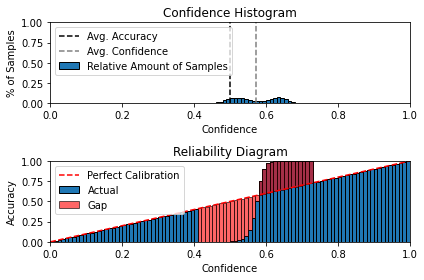

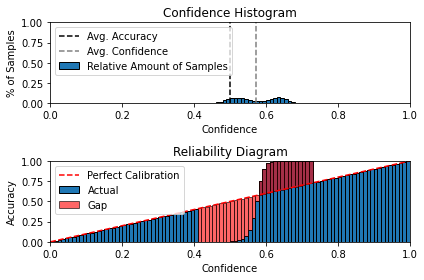

In [35]:
from netcal.presentation import ReliabilityDiagram

#n_bins = [10, 10]
n_bins= [100]

diagram = ReliabilityDiagram(n_bins, detection=False)    # flag 'detection=True' is mandatory for this method
diagram.plot(confidences, ground_truth)                # visualize miscalibration of uncalibrated

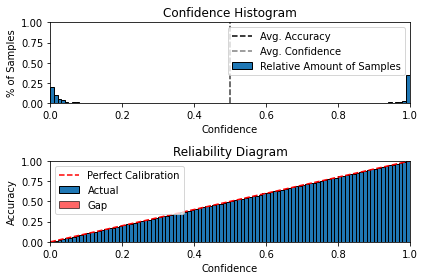

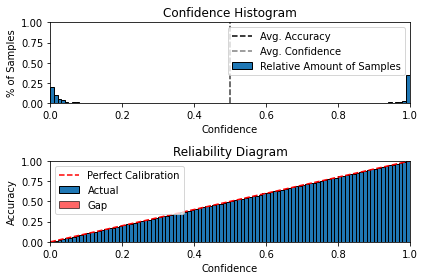

In [36]:
diagram.plot(calibrated, ground_truth)     # visualize miscalibration of calibrated

In [37]:
fname='VoxCeleb1-O_aamsoftmax_eer1.7338.score'
tscores = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        tscores[k1+' ' + k2] = float(s)
#print(scores)
#print(scores.keys())
#print(scores['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

fname = 'veri_test.txt'
tlabels = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        tlabels[k1+' ' + k2] = int(s)
#print(labels['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

In [38]:
confidences=np.array(list(tscores.values()))
ground_truth=np.array(list(tlabels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
calibrated = temperature.transform(confidences)
print(calibrated[:5])

n_bins = 10
ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)


compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)

EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[0.99840849 0.04915627 1.         0.00338753 1.        ]
ECE
0.39419344243197585
0.010102175326190475
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5597 (threshold 0.4398)
minDCF : 0.1027 (threshold 0.9066 p-target=0.05, c-miss=1, c-fa=1)


(0.10265111346765599, 0.9066339066339066)

EER : 4.5293 (threshold 0.2853)
minDCF : 0.2419 (threshold 0.4069 p-target=0.05, c-miss=1, c-fa=1)
[0.64835246 0.66200946 0.49549598 0.48960965 0.57576869]
[1 1 0 0 0]
[1.         1.         0.00321038 0.00321038 0.53890825]
ECE
0.37419891553950724
1.7735023811062528e-13
EER : 4.5293 (threshold 0.5708)
minDCF : 0.2419 (threshold 0.6003 p-target=0.05, c-miss=1, c-fa=1)
EER : 4.5193 (threshold 0.4363)
minDCF : 0.2412 (threshold 0.9506 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5642 (threshold 0.2881)
minDCF : 0.1043 (threshold 0.3907 p-target=0.05, c-miss=1, c-fa=1)
[0.62927622 0.54291166 0.6525611  0.49725677 0.64592041]
[1 0 1 0 1]
[0.99903069 0.05816555 1.         0.00334169 0.99982833]
ECE
0.39419344243197585
0.008892813503133121
EER : 1.5642 (threshold 0.5715)
minDCF : 0.1043 (threshold 0.5965 p-target=0.05, c-miss=1, c-fa=1)
EER : 1.5576 (threshold 0.4165)
minDCF : 0.1031 (threshold 0.9073 p-target=0.05, c-miss=1, c-fa=1)


(0.10312831389183551, 0.907258064516129)

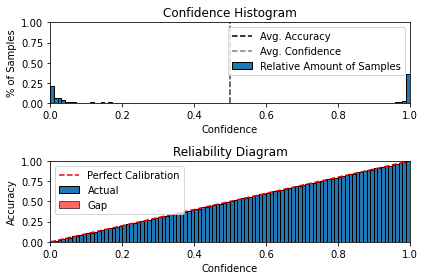

In [41]:
from netcal.binning import IsotonicRegression

temperature = IsotonicRegression()

confidences=np.array(list(scores.values()))
ground_truth=np.array(list(labels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)
print(calibrated[:5])



from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)



compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)


# plot

diagram.plot(calibrated, ground_truth)     # visualize miscalibration of calibrated


# test on other data

fname='VoxCeleb1-O_aamsoftmax_eer1.7338.score'
tscores = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        tscores[k1+' ' + k2] = float(s)
#print(scores)
#print(scores.keys())
#print(scores['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])

fname = 'veri_test.txt'
tlabels = {}
with open(fname, 'r') as f:
    for line in f:
        s, k1, k2 = line.strip().split()
        tlabels[k1+' ' + k2] = int(s)
#print(labels['id10270/x6uYqmx31kE/00001.wav id10270/8jEAjG6SegY/00008.wav'])



confidences=np.array(list(tscores.values()))
ground_truth=np.array(list(tlabels.values()))

compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)

confidences = sigmoid(confidences)
print(confidences[:5])
print(ground_truth[:5])
calibrated = temperature.transform(confidences)
print(calibrated[:5])

n_bins = 10
ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('ECE')
print(uncalibrated_score)
print(calibrated_score)


compute_eer(confidences, ground_truth)
compute_minDCF(confidences, ground_truth)
compute_eer(calibrated, ground_truth)
compute_minDCF(calibrated, ground_truth)